<a href="https://colab.research.google.com/github/MarriumJilani/Comparative-Analysis-of-Human-Pose-Estimation-Models-for-Yoga-Poses/blob/main/OpenPose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files

# Upload kaggle.json
uploaded = files.upload()

# Move the uploaded file to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
# Replace 'dataset-url' with the actual URL of the dataset
!kaggle datasets download -d niharika41298/yoga-poses-dataset



 99% 284M/288M [00:02<00:00, 166MB/s]
100% 288M/288M [00:02<00:00, 143MB/s]


In [ ]:
# Unzip the downloaded dataset
!unzip -q /content/yoga-poses-dataset.zip -d dataset

In [ ]:
!ls
!ls /content/dataset
!ls /content/dataset/DATASET
!ls /content/dataset/DATASET/TEST
!ls /content/dataset/DATASET/TRAIN

dataset  sample_data  yoga-poses-dataset.zip
DATASET
TEST  TRAIN
downdog  goddess  plank  tree  warrior2
downdog  goddess  plank  tree  warrior2


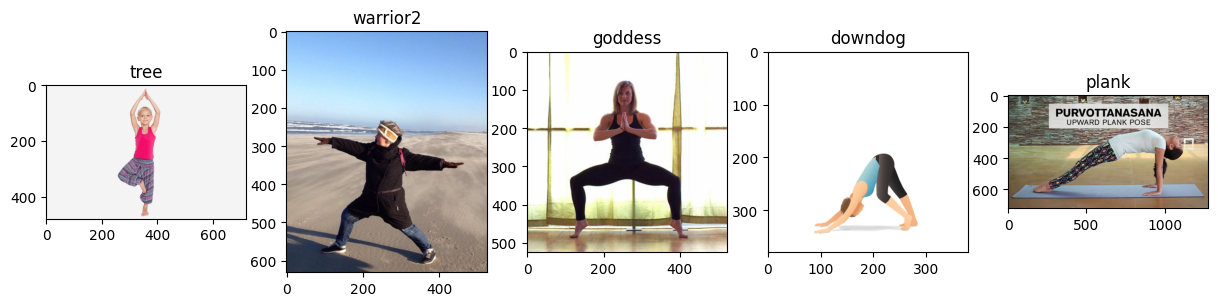

In [ ]:
import os
# Load the dataset
data_path = '/content/dataset/DATASET'
train_path = os.path.join(data_path, 'TRAIN')
test_path = os.path.join(data_path, 'TEST')

# Use the OS library to list classes in the dataset
classes = os.listdir(train_path)

# Visualize one sample for each class
import matplotlib.pyplot as plt
import cv2

# Display one sample image for each class
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))

for i, class_label in enumerate(classes):
    class_path = os.path.join(train_path, class_label)
    sample_image = os.path.join(class_path, os.listdir(class_path)[0])
    image = cv2.imread(sample_image)
    axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[i].set_title(class_label)

plt.show()




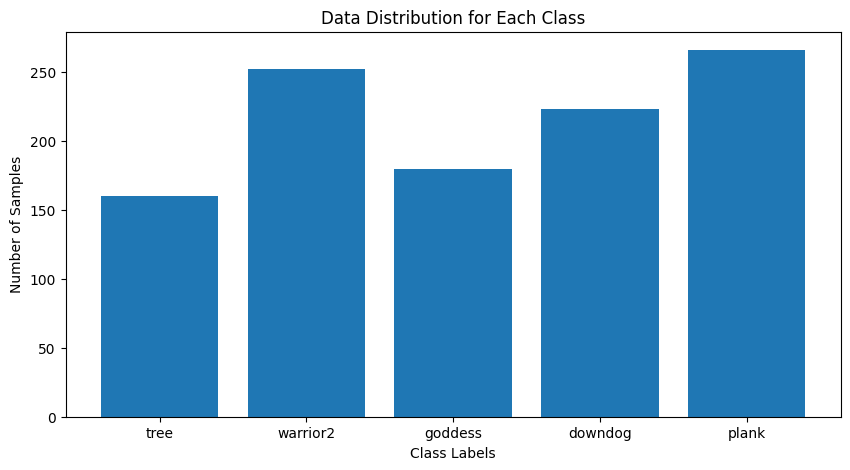

In [ ]:
# Graphical data distribution for each class using a bar chart
class_counts = {class_label: len(os.listdir(os.path.join(train_path, class_label))) for class_label in classes}

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Data Distribution for Each Class")
plt.xlabel("Class Labels")
plt.ylabel("Number of Samples")
plt.show()

# Check for class imbalances
min_samples = min(class_counts.values())
max_samples = max(class_counts.values())
class_imbalance_threshold = 0.8

if max_samples / min_samples > class_imbalance_threshold:
    print("Warning: There might be class imbalance.")
else:
    print("No significant class imbalance observed.")

In [ ]:
import cv2

# Load an example image from your dataset
example_image_path = "/content/dataset/DATASET/TEST/goddess/00000058.jpg"
example_image = cv2.imread(example_image_path)

# Get the image dimensions
img_height, img_width, _ = example_image.shape

print("Image Height:", img_height)
print("Image Width:", img_width)


Image Height: 1000
Image Width: 1000


# Open Pose


In [ ]:
!git clone https://github.com/misbah4064/human-pose-estimation-opencv.git
%cd human-pose-estimation-opencv/

Cloning into 'human-pose-estimation-opencv'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 20 (delta 5), reused 17 (delta 5), pack-reused 0
Receiving objects: 100% (20/20), 10.09 MiB | 11.48 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/human-pose-estimation-opencv


In [ ]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow

BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

width = 368
height = 368
inWidth = width
inHeight = height

net = cv.dnn.readNetFromTensorflow("graph_opt.pb")
thr = 0.2

def poseDetector(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()

    return frame

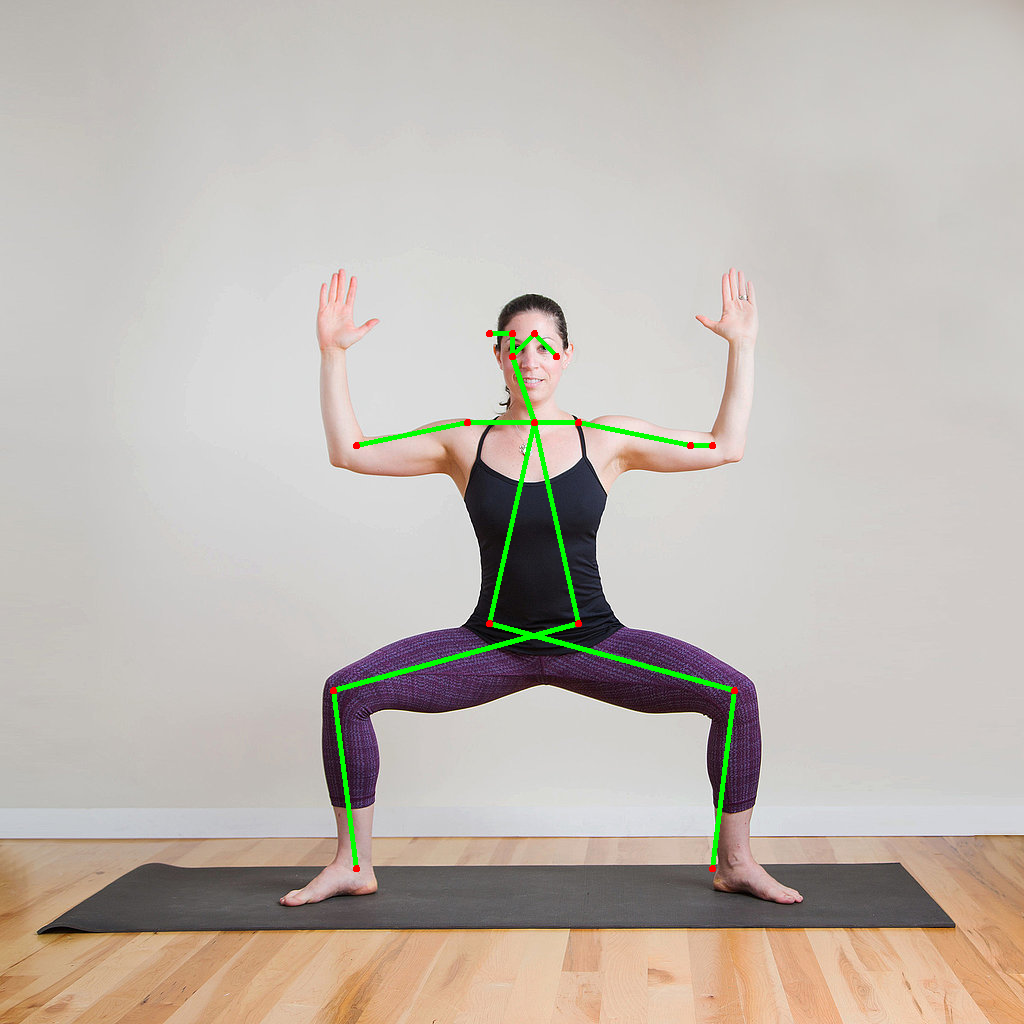

In [ ]:
input = cv.imread("/content/dataset/DATASET/TEST/goddess/00000000.jpg")
output = poseDetector(input)
cv2_imshow(output)

In [ ]:
import cv2
import os
import json

# Load OpenPose model
net = cv2.dnn.readNetFromTensorflow("graph_opt.pb")
thr = 0.2

def pose_detector(frame):
    frame_width = frame.shape[1]
    frame_height = frame.shape[0]

    net.setInput(cv2.dnn.blobFromImage(frame, 1.0, (368, 368), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # Use the first 19 elements

    # Process the output as needed
    # Example: Store keypoints in a list
    keypoints = []
    for i in range(out.shape[1]):
        heat_map = out[0, i, :, :]
        _, conf, _, point = cv2.minMaxLoc(heat_map)
        x = (frame_width * point[0]) / out.shape[3]
        y = (frame_height * point[1]) / out.shape[2]
        keypoints.append((int(x), int(y)) if conf > thr else None)

    return keypoints


def process_dataset(data_path, output_path):
    images = []
    labels = []

    for class_label in os.listdir(data_path):
        class_path = os.path.join(data_path, class_label)
        output_class_path = os.path.join(output_path, class_label)
        os.makedirs(output_class_path, exist_ok=True)

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = cv2.imread(image_path)
            keypoints = pose_detector(img)

            # Save keypoints or relevant information to a file (e.g., JSON)
            output_file = os.path.join(output_class_path, image_name.split('.')[0] + '_keypoints.json')
            with open(output_file, 'w') as f:
                json.dump(keypoints, f)

            # Append keypoints and label
            flattened_keypoints = [coord for point in keypoints for coord in (point or [0, 0])]
            images.append(flattened_keypoints)
            labels.append(class_label)

    return np.array(images), np.array(labels)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import os
import json

import re

def load_keypoints_data(data_path):
    images = []
    labels = []

    for class_label, class_name in enumerate(os.listdir(data_path)):
        class_path = os.path.join(data_path, class_name)

        for filename in os.listdir(class_path):
            if filename.endswith("_keypoints.json"):
                keypoints_path = os.path.join(class_path, filename)

                # Extract class label from the file path using regex
                match = re.match(r'.*\/([^\/]+)\/.*', keypoints_path)
                if match:
                    class_label = match.group(1)

                # Load keypoints from JSON file
                with open(keypoints_path, 'r') as f:
                    keypoints = json.load(f)

                # Flatten the keypoints list
                flattened_keypoints = [coord for point in keypoints for coord in (point or [0, 0])]

                # Append keypoints and label
                images.append(flattened_keypoints)
                #print(class_label)
                labels.append(class_label)

    return np.array(images), np.array(labels)

# CNN Model Architecture
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(input_shape,)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



In [ ]:
# Process both training and test datasets
data_path_train = '/content/dataset/DATASET/TRAIN'
output_path_train = '/content/dataset/OpenPoseOutputTrain'
train_images, train_labels = process_dataset(data_path_train, output_path_train)

data_path_test = '/content/dataset/DATASET/TEST'
output_path_test = '/content/dataset/OpenPoseOutputTest'
test_images, test_labels = process_dataset(data_path_test, output_path_test)



In [ ]:
from sklearn.preprocessing import LabelEncoder
# Create CNN model
#cnn_model = create_cnn_model(input_shape=train_images.shape[1])

num_classes = len(set(train_labels))  # Number of unique classes in training data
print(num_classes)
cnn_model = create_cnn_model(input_shape=train_images.shape[1], num_classes=num_classes)


# Convert string labels to numeric labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Model Training

cnn_model.fit(train_images, train_labels_encoded, epochs=25, validation_data=(test_images, test_labels_encoded))


# Convert string labels to numeric labels for test data
label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)

# Model Evaluation
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels_encoded)
print(f'Test Accuracy: {test_acc}')


# Save the entire model after training
cnn_model.save('/content/dataset/CNNModel/yoga_pose_cnn_model.h5')



5
Epoch 1/25
34/34 [==============================] - 1s 10ms/step - loss: 247.8947 - accuracy: 0.2146 - val_loss: 56.2993 - val_accuracy: 0.3617
Epoch 2/25
34/34 [==============================] - 0s 5ms/step - loss: 118.9155 - accuracy: 0.2461 - val_loss: 25.8045 - val_accuracy: 0.3511
Epoch 3/25
34/34 [==============================] - 0s 5ms/step - loss: 72.9856 - accuracy: 0.2720 - val_loss: 15.6645 - val_accuracy: 0.3106
Epoch 4/25
34/34 [==============================] - 0s 4ms/step - loss: 49.4400 - accuracy: 0.2516 - val_loss: 8.0791 - val_accuracy: 0.3170
Epoch 5/25
34/34 [==============================] - 0s 6ms/step - loss: 33.1762 - accuracy: 0.2710 - val_loss: 4.3145 - val_accuracy: 0.2745
Epoch 6/25
34/34 [==============================] - 0s 5ms/step - loss: 25.5850 - accuracy: 0.2544 - val_loss: 2.2721 - val_accuracy: 0.2723
Epoch 7/25
34/34 [==============================] - 0s 5ms/step - loss: 16.9118 - accuracy: 0.2701 - val_loss: 1.8230 - val_accuracy: 0.2191
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 0s 5ms/step


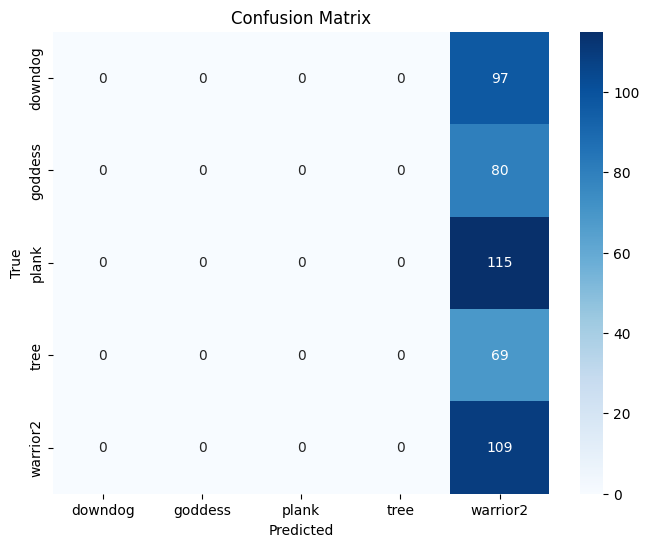

              precision    recall  f1-score   support

     downdog       0.00      0.00      0.00        97
     goddess       0.00      0.00      0.00        80
       plank       0.00      0.00      0.00       115
        tree       0.00      0.00      0.00        69
    warrior2       0.23      1.00      0.38       109

    accuracy                           0.23       470
   macro avg       0.05      0.20      0.08       470
weighted avg       0.05      0.23      0.09       470



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Replace this with the actual class names in your dataset
class_names = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']

# Apply the trained model to the test data
predictions = cnn_model.predict(test_images)

# Convert predictions to class labels
predicted_labels = label_encoder.inverse_transform(predicted_labels)

# Calculate and display the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Evaluate the model's performance
print(classification_report(test_labels, predicted_labels, target_names=class_names))

